In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install xFormers

  Using cached xformers-0.0.28.post1.tar.gz (7.8 MB)



ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\JHK\\AppData\\Local\\Temp\\pip-install-5akqgwnw\\xformers_ba126315137b467ea5f6eb5aa90e5aca\\third_party/flash-attention/csrc/composable_kernel/client_example/24_grouped_conv_activation/grouped_convnd_bwd_data_bilinear/grouped_conv_bwd_data_bilinear_residual_fp16.cpp'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



In [5]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14

Using cache found in C:\Users\JHK/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate=none)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedTen

In [3]:
dinov2_vits14_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')
dinov2_vits14_lc

Using cache found in C:\Users\JHK/.cache\torch\hub\facebookresearch_dinov2_main


_LinearClassifierWrapper(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0): NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate=none)
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
       

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    
])


train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


for images, labels in train_loader:
    print(images.shape, labels.shape)  
    break  

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [7]:
dinov2_vits14.eval()
val=None
with torch.no_grad():
    val = dinov2_vits14.get_intermediate_layers(train_dataset[0][0].unsqueeze(dim=0), 4, return_class_token=True)

In [8]:
def create_linear_input(x_tokens_list, use_n_blocks, use_avgpool):
    intermediate_output = x_tokens_list[-use_n_blocks:]
    output = torch.cat([class_token for _, class_token in intermediate_output], dim=-1)
    if use_avgpool:
        output = torch.cat(
            (
                output,
                torch.mean(intermediate_output[-1][0], dim=1),  # patch tokens
            ),
            dim=-1,
        )
        output = output.reshape(output.shape[0], -1)
    return output.float()

print(val[0][1].shape)
print(torch.mean(val[-1][0],dim=1).shape)
new = create_linear_input(val, 1, True)
new.shape
#val["x_norm_clstoken"][-1:].shape
#train_dataset[0][0].unsqueeze(0).shape

torch.Size([1, 384])
torch.Size([1, 384])


torch.Size([1, 768])

In [9]:
from torch import nn
class LinearHead(nn.Module):
    def __init__(self, in_features=1920, out_features=102, bias=True):
        super(LinearHead, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.linear(x)
        return self.softmax(x)
head = LinearHead()

In [110]:
input_dim = 1920 
num_classes = 102  
learning_rate = 1e-3
num_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dinov2_vits14.to(device)
import torch.optim as optim


model = LinearHead(in_features=input_dim, out_features=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (imgs, labels) in enumerate(train_loader):
        
        imgs = imgs.to(device)  
        labels = labels.to(device)  
        
        
        feature=None
        with torch.no_grad():
            feature = dinov2_vits14.get_intermediate_layers(imgs, 4, return_class_token=True)
            feature = create_linear_input(feature, 1, True)
            
        outputs = model(feature)
        loss = criterion(outputs, labels)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        if i > 0:
            break

        if i % 100 == 99: 
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # validate that shit
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for img, labels in val_loader:
            feature = dinov2_vits14.get_intermediate_layers(imgs, 4, return_class_token=True)
            feature = create_linear_input(feature, 4, True)
            
            img = img.to(device)
            labels = labels.to(device)
            outputs = model(feature)
            
            _, predicted = torch.max(outputs.data, 1)
            print(predicted.shape, labels.shape)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Validation Accuracy after Epoch {epoch+1}: {accuracy:.2f}%')

print('Finished Training')


torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32]) torch.Size([32])
torch.Size([32

RuntimeError: The size of tensor a (32) must match the size of tensor b (28) at non-singleton dimension 0

In [10]:
from torch.utils.data import DataLoader, random_split
batch_size = 16
#CIFAR10
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2587, 0.2093, 0.2210]),
    #transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
    ])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2587, 0.2093, 0.2210]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2587, 0.2093, 0.2210]),
])

# CIFAR10 Dataset
train_dataset_CIFAR10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset_CIFAR10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader_CIFAR10 = DataLoader(train_dataset_CIFAR10, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader_CIFAR10 = DataLoader(test_dataset_CIFAR10, batch_size=batch_size, shuffle=False, num_workers=4)

"""
#CIFAR100
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2587, 0.2093, 0.2210]),
    transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
    ])

train_dataset_CIFAR100 = datasets.Cifar100(root='./data', split='train', download=True, transform=transform_train)
val_dataset_CIFAR100 = datasets.Cifar100(root='./data', split='val', download=True, transform=transform_val)
test_dataset_CIFAR100 = datasets.Cifar100(root='./data', split='test', download=True, transform=transform_test)

train_loader_CIFAR100 = DataLoader(train_dataset_CIFAR100, batch_size=8, shuffle=True, num_workers=4)
val_loader_CIFAR100 = DataLoader(val_dataset_CIFAR100, batch_size=8, shuffle=True, num_workers=4)
test_loader_CIFAR100 = DataLoader(test_dataset_CIFAR100, batch_size=8, shuffle=True, num_workers=4)

#SUN397
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2587, 0.2093, 0.2210]),
    transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
    ])

train_dataset_SUN397 = datasets.SUN397(root='./data', split='train', download=True, transform=transform_train)
val_dataset_SUN397 = datasets.SUN397(root='./data', split='val', download=True, transform=transform_val)
test_dataset_SUN397 = datasets.SUN397(root='./data', split='test', download=True, transform=transform_test)

train_loader_SUN397 = DataLoader(train_dataset_SUN397, batch_size=8, shuffle=True, num_workers=4)
val_loader_SUN397 = DataLoader(val_dataset_SUN397, batch_size=8, shuffle=True, num_workers=4)
test_loader_SUN397 = DataLoader(test_dataset_SUN397, batch_size=8, shuffle=True, num_workers=4)


#Stanford Cars
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2587, 0.2093, 0.2210]),
    transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
    ])

train_dataset_StanfordCars = datasets.StanfordCars(root='./data', split='train', download=True, transform=transform_train)
val_dataset_StanfordCars = datasets.StanfordCars(root='./data', split='val', download=True, transform=transform_val)
test_dataset_StanfordCars = datasets.StanfordCars(root='./data', split='test', download=True, transform=transform_test)

train_loader_StanfordCars = DataLoader(train_dataset_StanfordCars, batch_size=8, shuffle=True, num_workers=4)
val_loader_StanfordCars = DataLoader(val_dataset_StanfordCars, batch_size=8, shuffle=True, num_workers=4)
test_loader_StanfordCars = DataLoader(test_dataset_StanfordCars, batch_size=8, shuffle=True, num_workers=4)
"""
"""
#Pascal VOC
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.functional.pil_to_tensor,
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2587, 0.2093, 0.2210]),
    #transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
    ])

train_dataset_PascalVOC = datasets.VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform_train)
val_dataset_PascalVOC = datasets.VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform_val)
#test_dataset_PascalVOC = datasets.VOCSegmentation(root='./data', year='2012', image_set='test', download=True, transform=transform_test)

train_loader_PascalVOC = DataLoader(train_dataset_PascalVOC, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader_PascalVOC = DataLoader(val_dataset_PascalVOC, batch_size=batch_size, shuffle=True, num_workers=4)
#test_loader_PascalVOC = DataLoader(test_dataset_PascalVOC, batch_size=batch_size, shuffle=True, num_workers=4)
"""

#DTD
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2587, 0.2093, 0.2210]),
    #transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
    ])

train_dataset_DTD = datasets.DTD(root='./data', split='train', download=True, transform=transform_train)
val_dataset_DTD = datasets.DTD(root='./data', split='val', download=True, transform=transform_val)
test_dataset_DTD = datasets.DTD(root='./data', split='test', download=True, transform=transform_test)

train_loader_DTD = DataLoader(train_dataset_DTD, batch_size=8, shuffle=True, num_workers=4)
val_loader_DTD = DataLoader(val_dataset_DTD, batch_size=8, shuffle=True, num_workers=4)
test_loader_DTD = DataLoader(test_dataset_DTD, batch_size=8, shuffle=True, num_workers=4)


#Oxford-IIIT Pets
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2587, 0.2093, 0.2210]),
    #transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
    ])

train_dataset_OxfordIIITPet = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform_train)
val_dataset_OxfordIIITPet = datasets.OxfordIIITPet(root='./data', split='test', download=True, transform=transform_val)
#test_dataset_OxfordIIITPet = datasets.OxfordIIITPet(root='./data', split='test', download=True, transform=transform_test)

train_loader_OxfordIIITPet = DataLoader(train_dataset_OxfordIIITPet, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader_OxfordIIITPet = DataLoader(val_dataset_OxfordIIITPet, batch_size=batch_size, shuffle=True, num_workers=4)
#test_loader_OxfordIIITPet = DataLoader(test_dataset_OxfordIIITPet, batch_size=batch_size, shuffle=True, num_workers=4)



data_loaders = {
    'DTD': [train_loader_DTD, val_loader_DTD],
    'Flowers102': [train_loader, val_loader],
    #'Food101': [train_loader_food, val_loader_food, test_loader_food],
    'CIFAR10': [train_loader_CIFAR10, test_loader_CIFAR10],
    #'CIFAR100': [train_loader_CIFAR100, val_loader_CIFAR100, test_loader_CIFAR100],
    #'SUN397': [train_loader_SUN397, val_loader_SUN397, test_loader_SUN397],
    #'StanfordCars': [train_loader_StanfordCars, val_loader_StanfordCars, test_loader_StanfordCars],
    #'PascalVOC': [train_loader_PascalVOC, val_loader_PascalVOC],
    'OxfordIIITPet': [train_loader_OxfordIIITPet, val_loader_OxfordIIITPet],
    #'Caltech101': [train_loader_Caltech101, val_loader_Caltech101, test_loader_Caltech101],
}





Files already downloaded and verified
Files already downloaded and verified


In [40]:
for key in data_loaders.keys():
    train, _ = data_loaders[key]
    mean, std = calculate_mean_std(train) 
    classes = get_unique_classes(train)
    print(key, mean, std)
    print("CLASSES:",  classes)
    

DTD tensor([0.5288, 0.4731, 0.4247]) tensor([0.1688, 0.1694, 0.1653])
CLASSES: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}
Flowers102 tensor([0.4330, 0.3819, 0.2964]) tensor([0.2587, 0.2093, 0.2210])
CLASSES: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101}
CIFAR10 tensor([0.4914, 0.4822, 0.4465]) tensor([0.1953, 0.1925, 0.1942])
CLASSES: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
OxfordIIITPet tensor([0.4783, 0.4459, 0.3957]) tensor([0.2254, 0.2223, 0.2240])
CLASSES: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1

In [11]:
def calculate_mean_std(dataloader):
    
    mean = 0.0
    std = 0.0
    total_images_count = 0
    
    for images, _ in dataloader:
        
        images = images.view(images.size(0), images.size(1), -1)
        
        
        total_images_count += images.size(0)
        
        
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    
    
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

def get_unique_classes(dataloader):
    
    unique_classes = set()
    
    
    for _, labels in dataloader:
        
        unique_classes.update(labels.numpy())
    
    return unique_classes


torch.Size([1, 256, 384])


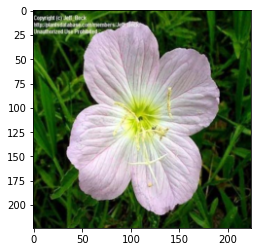

In [12]:
arr = train_dataset[1][0]

print(dinov2_vits14.get_intermediate_layers(arr.unsqueeze(0), 1, False)[0].shape)
plt.imshow(np.transpose(arr, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

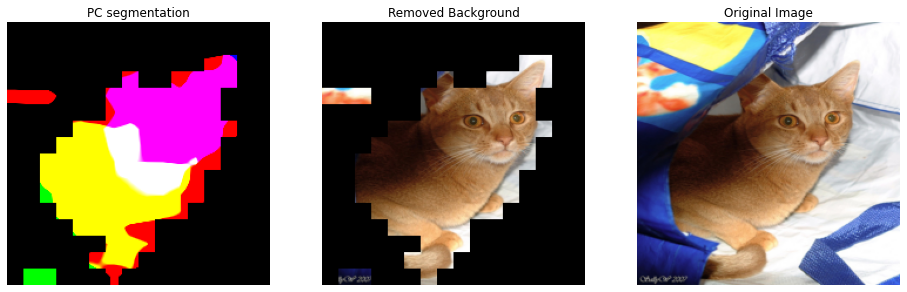

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

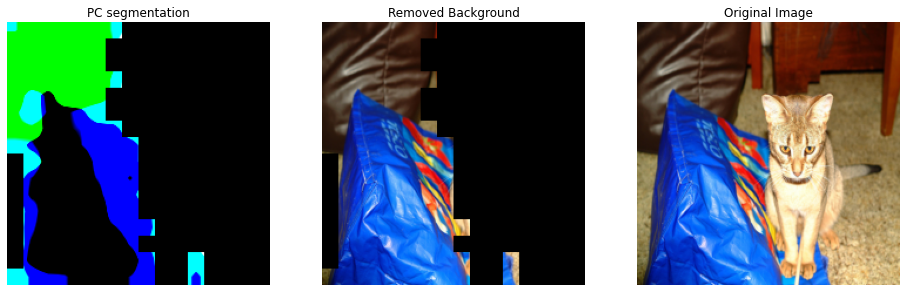

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

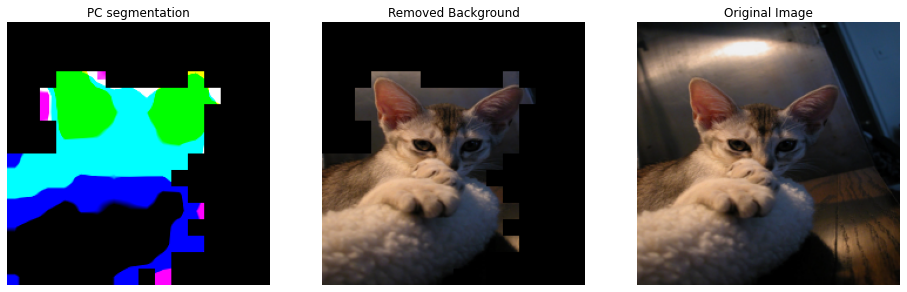

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

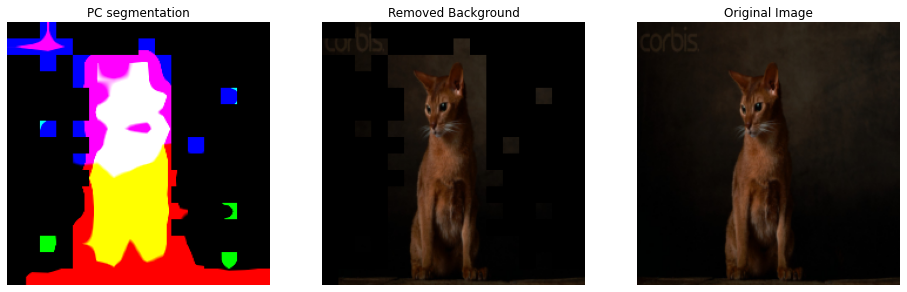

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

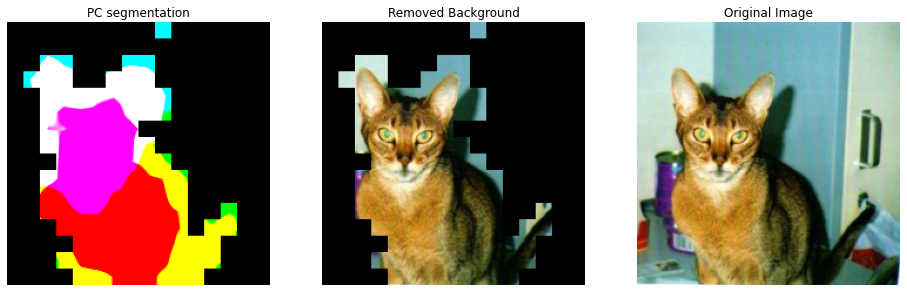

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

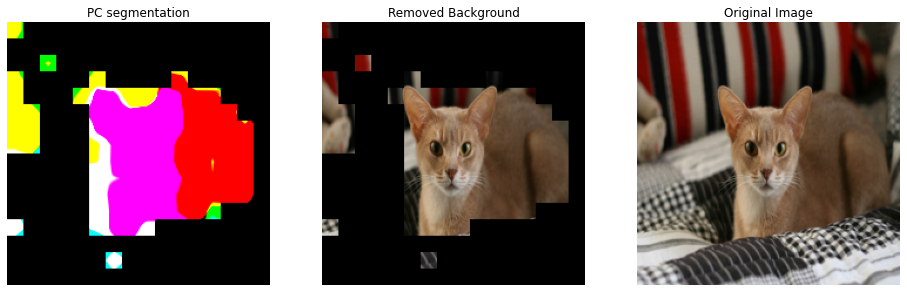

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

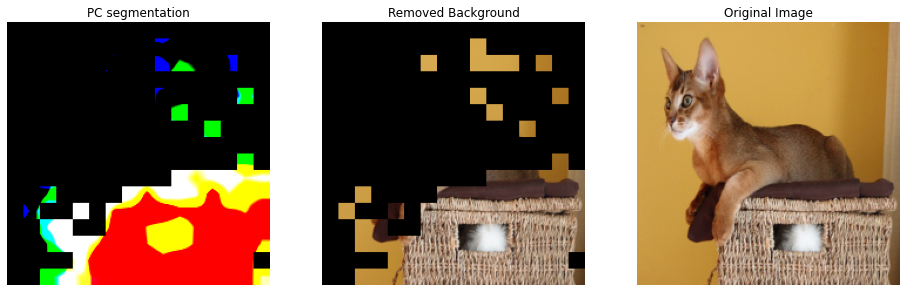

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

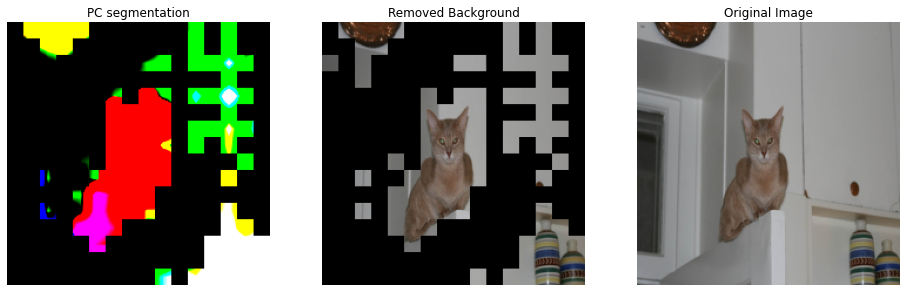

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

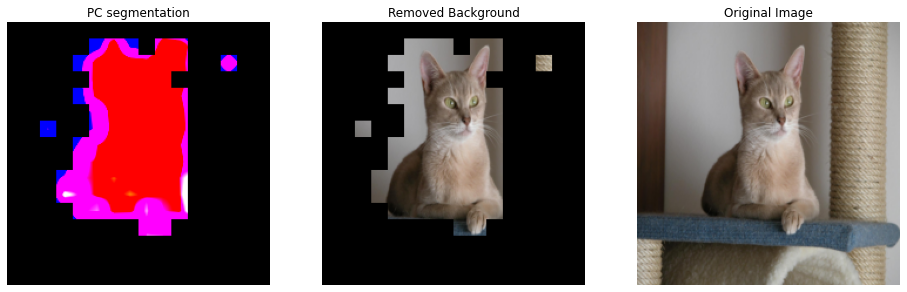

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

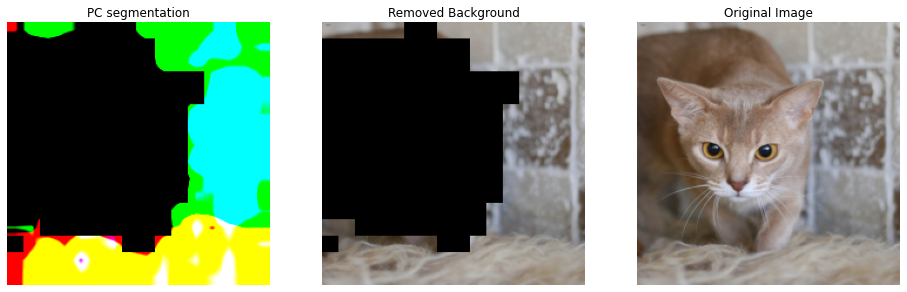

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

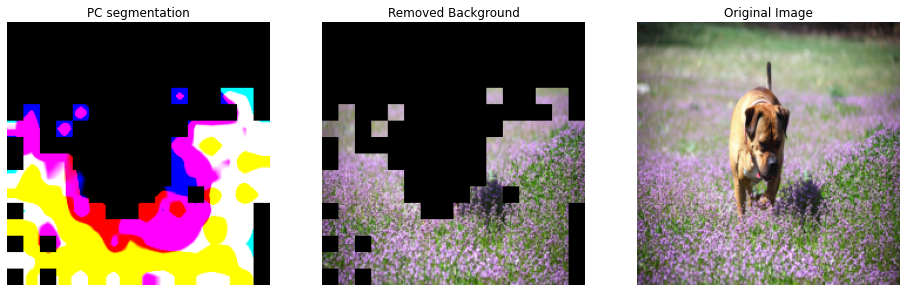

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

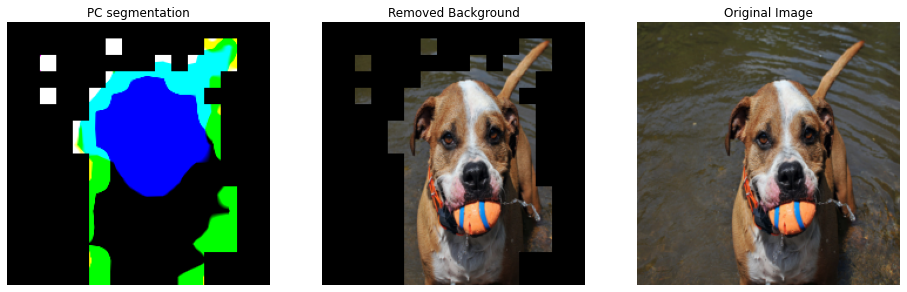

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

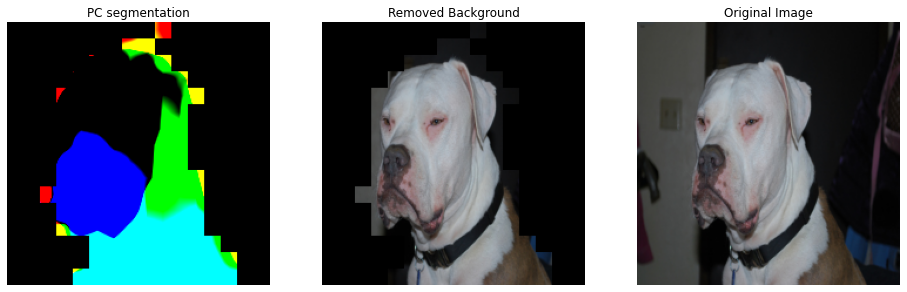

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

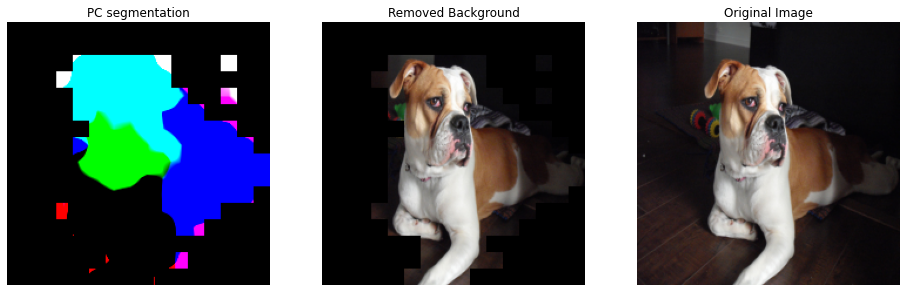

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

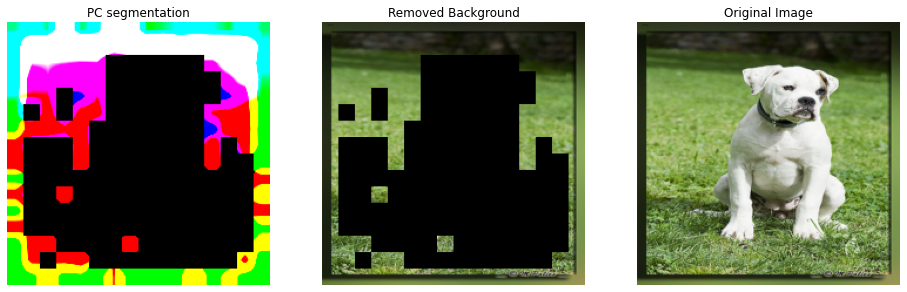

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

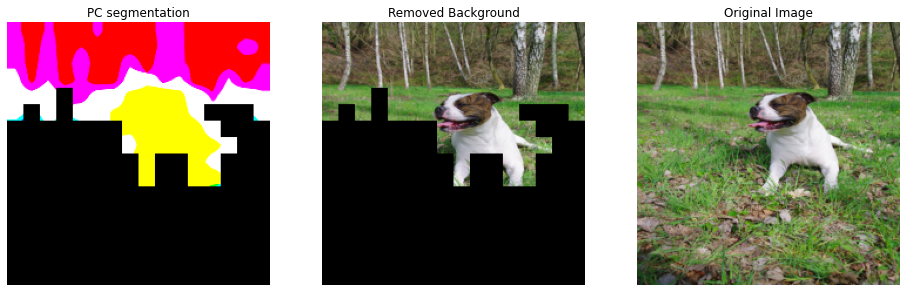

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

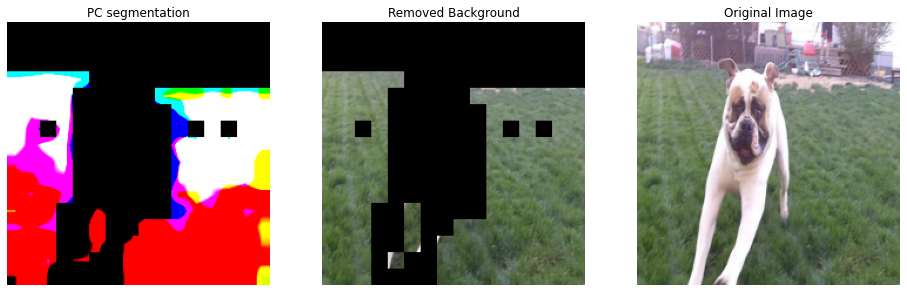

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

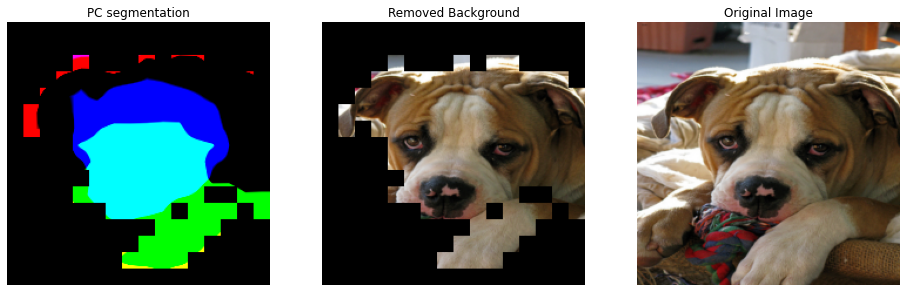

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

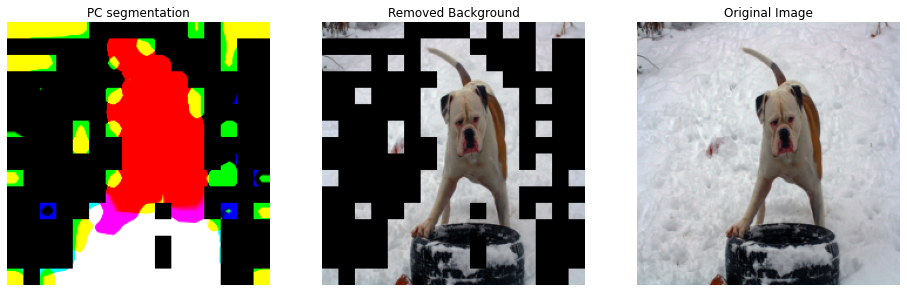

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

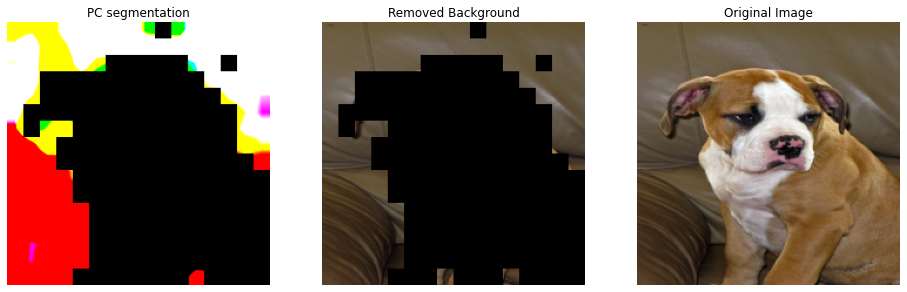

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

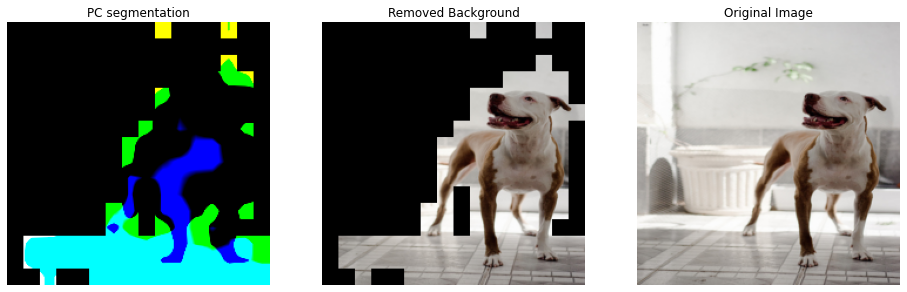

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

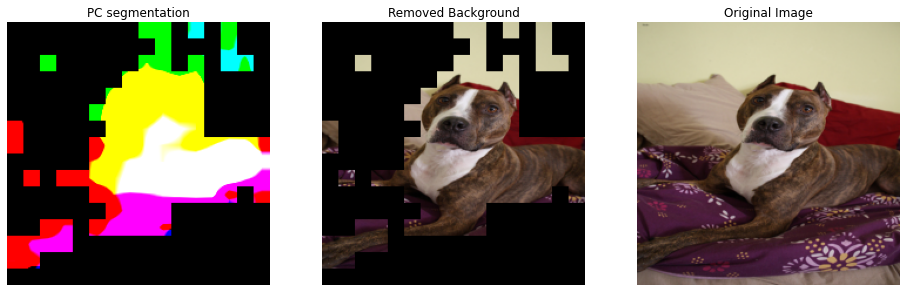

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

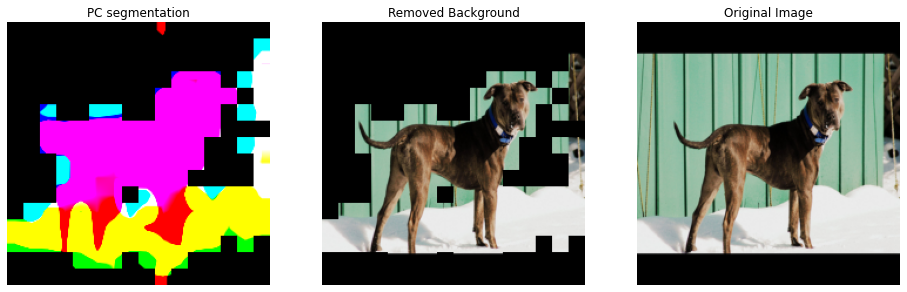

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

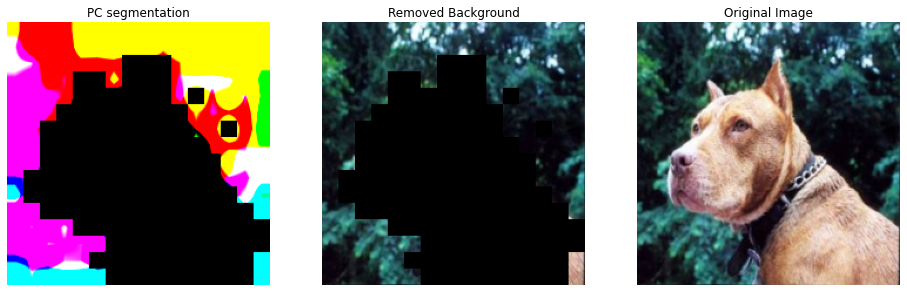

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

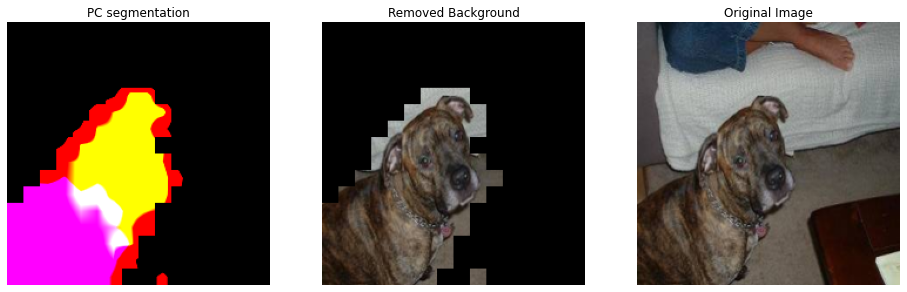

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

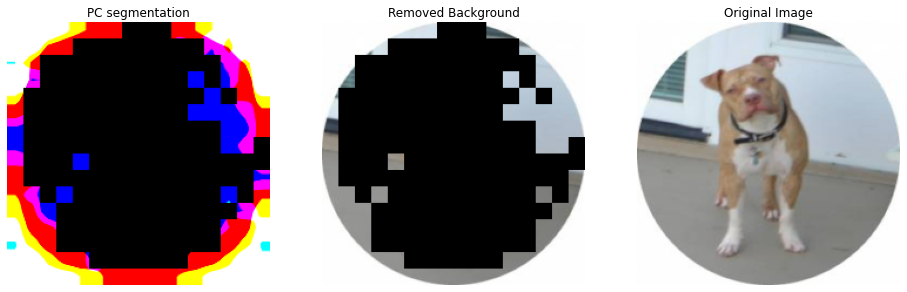

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

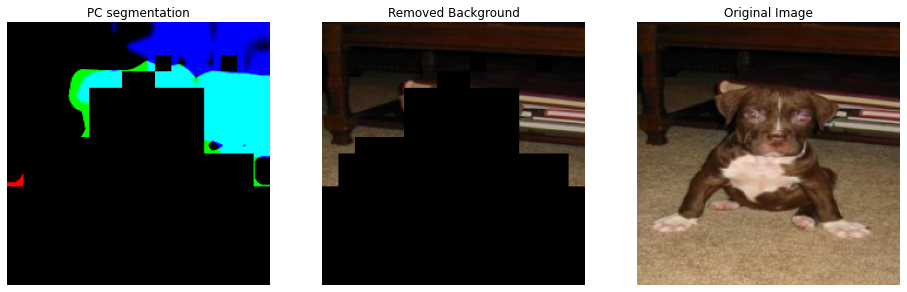

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

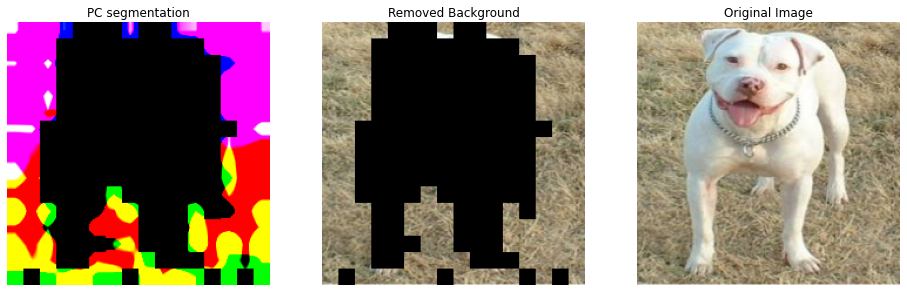

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

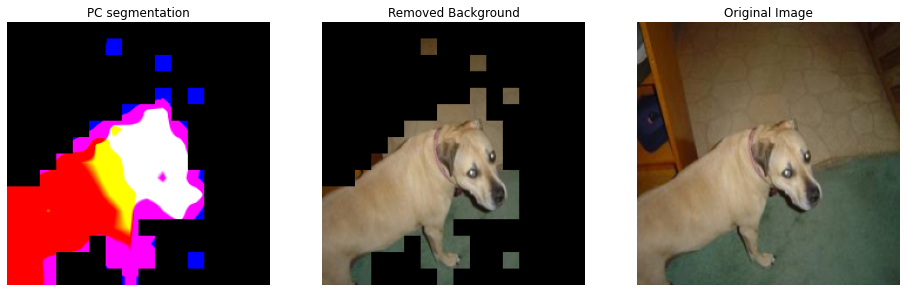

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

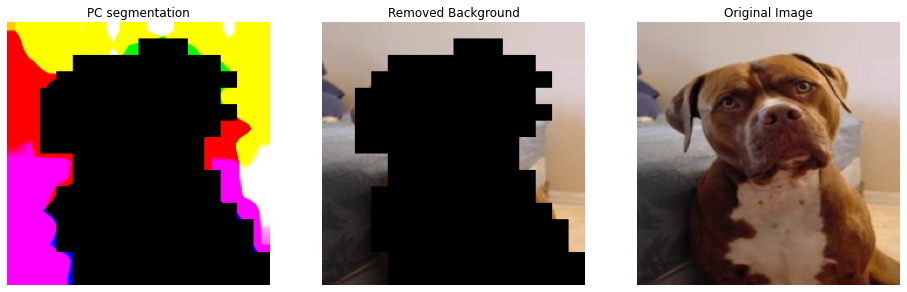

In [80]:
import numpy as np
import cv2  # For image manipulation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import copy
import warnings
import numpy as np

def extract_patches(image, patch_size=(14, 14), stride=14):
    h, w, c = image.shape
    patch_h, patch_w = patch_size
    patches = []
    indices = []

    for i in range(0, h - patch_h + 1, stride):
        for j in range(0, w - patch_w + 1, stride):
            patch = image[i:i + patch_h, j:j + patch_w, :] 
            patches.append(patch)
            indices.append((i, j))  
    
    patches = np.array(patches)
    return patches, indices



def perform_pca(features, n_components=3):
    pca = PCA(n_components=n_components)
    transformed_features = pca.fit_transform(features)
    return pca, transformed_features


def threshold_pca_component(pca_components, threshold=0):
    first_component = pca_components[:, 0] 
    mask = first_component > threshold 
    return mask


def visualize_pca_results(pca_components, image_shape):
    n_components = pca_components.shape[1]
    
    
    reshaped_components = []
    patch_size = 14  
    num_patches = pca_components.shape[0]  

    
    for i in range(n_components):
    
        reshaped = np.zeros((num_patches // (image_shape[1] // patch_size), image_shape[1] // patch_size))
        reshaped = pca_components[:, i].reshape(reshaped.shape)
        reshaped_components.append(reshaped)

    
    rgb_image = np.stack(reshaped_components[:3], axis=-1)
    return rgb_image
    #plt.imshow(rgb_image, cmap='gray')
    #plt.title("PCA Components Visualization")
    #plt.axis('off')  # Hide axis
    #plt.show()
"""    
def visualize_pca_results(pca_components, num_patches, patch_size):
    n_components = pca_components.shape[1]
    
    
    fig, axes = plt.subplots(1, min(n_components, 3), figsize=(15, 5))  # Limit to 3 components for display

    for i in range(min(n_components, 3)):
        
        reshaped = pca_components[:, i].reshape(int(np.sqrt(num_patches)), int(np.sqrt(num_patches)))
        axes[i].imshow(reshaped, cmap='gray')
        axes[i].set_title(f"PCA Component {i+1}")
        axes[i].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

"""

def process_image(image):
    
    features = dinov2_vits14.get_intermediate_layers(image.unsqueeze(0), 1, False)[0]
    features = features.detach().squeeze(0).numpy()
    
    
   
    pca, pca_components = perform_pca(features)

   
    foreground_mask = threshold_pca_component(pca_components)

   
    patches, indices = extract_patches(np.transpose(image, (1, 2, 0)), patch_size=(14, 14), stride=14)

    
    foreground_patches = patches[foreground_mask]

    
    reconstructed_image = np.transpose(image, (1, 2, 0))

    
    
    # Fill in the reconstructed image with the foreground patches
    for idx, (is_foreground, (i, j)) in enumerate(zip(foreground_mask, indices)):
        if not is_foreground:  # Only place valid patches
            reconstructed_image[i:i + 14, j:j + 14, :] = 0
    # Step 6: Visualize the reconstructed image
    #plt.imshow(reconstructed_image)
    #plt.title("Reconstructed Image with Foreground Patches")
    #plt.axis('off')
    #plt.show()
    

    new_features = dinov2_vits14.get_intermediate_layers(image.unsqueeze(0), 1, False)[0].detach().squeeze().numpy()
    
    
    
    second_pca, second_pca_components = perform_pca(new_features)


    final = visualize_pca_results(second_pca_components,reconstructed_image.shape)
    
    final = cv2.resize(final, (224,224))
    for idx, (is_foreground, (i, j)) in enumerate(zip(foreground_mask, indices)):
        if not is_foreground:  # Only place valid patches
            final[i:i + 14, j:j + 14, :] = 0
    #plt.imshow(final, cmap='gray')
    #plt.title("PCA Components Visualization")
    #plt.axis('off')  # Hide axis
    #plt.show()
    return reconstructed_image, final



with warnings.catch_warnings():
    warnings.simplefilter('ignore')


    for i in range(30):
        plt.figure(i)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
        arr = train_dataset_OxfordIIITPet[i*5][0]
        arr_org = np.transpose(copy.deepcopy(arr.numpy()),(1, 2, 0))

        recon, final = process_image(arr)

        arr = np.transpose(arr, (1, 2, 0))

        ax1.imshow(final, cmap='gray')

        ax1.set_title("PC segmentation")
        ax1.axis('off')  # Hide axis
        ax2.imshow(recon)
        ax2.set_title("Removed Background")
        ax2.axis('off')
        ax3.imshow(arr_org)
        ax3.set_title("Original Image")
        ax3.axis('off')
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

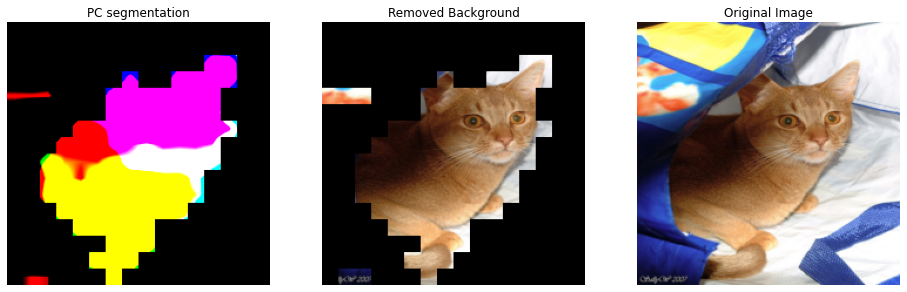

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

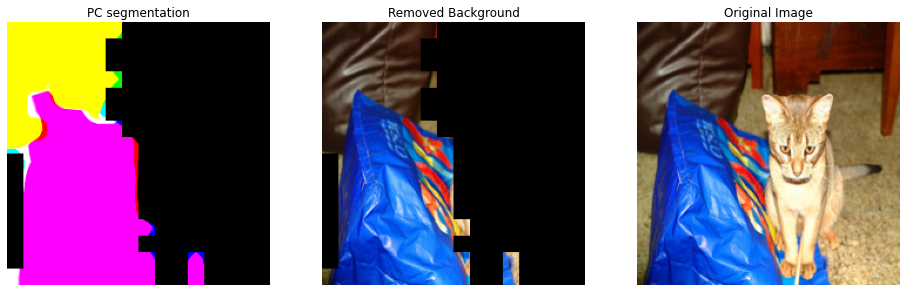

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

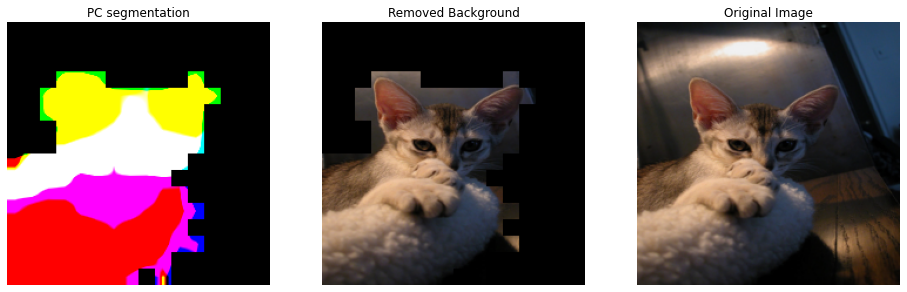

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

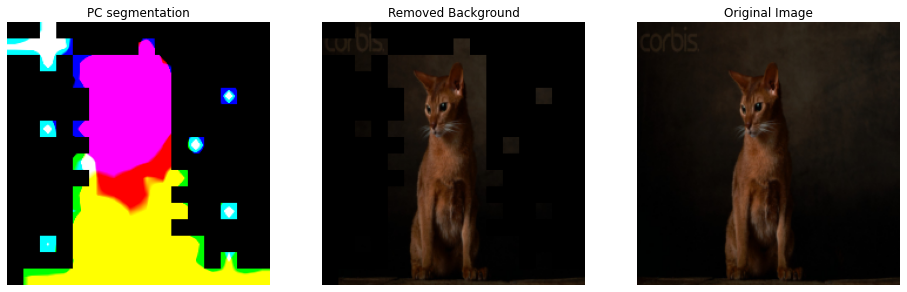

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

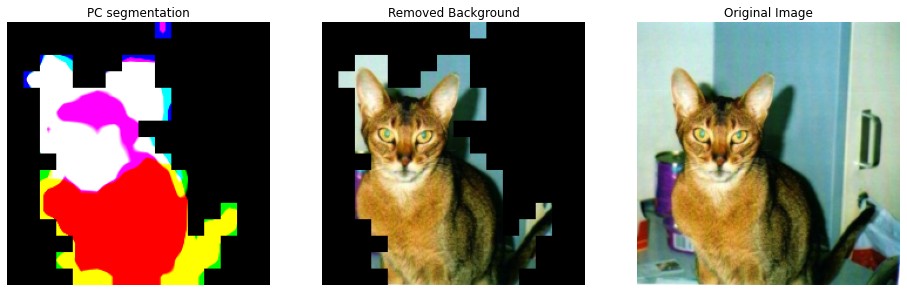

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

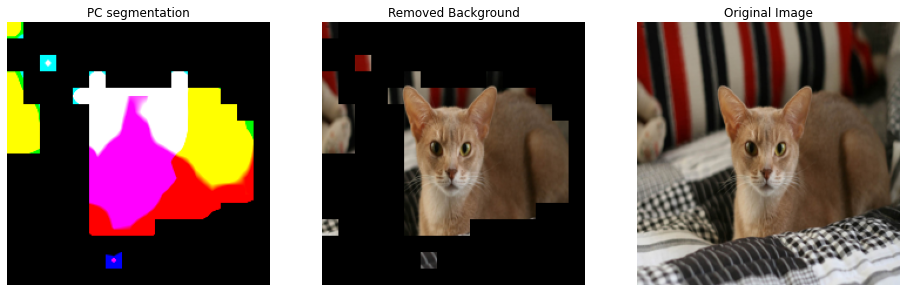

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

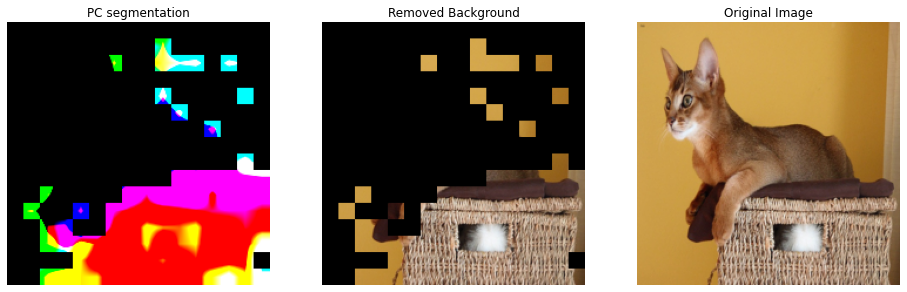

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

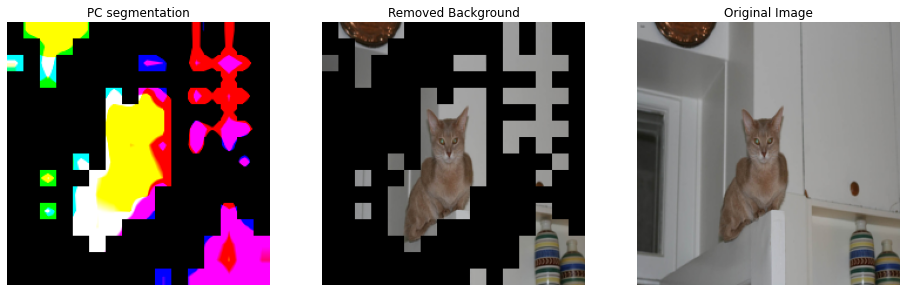

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

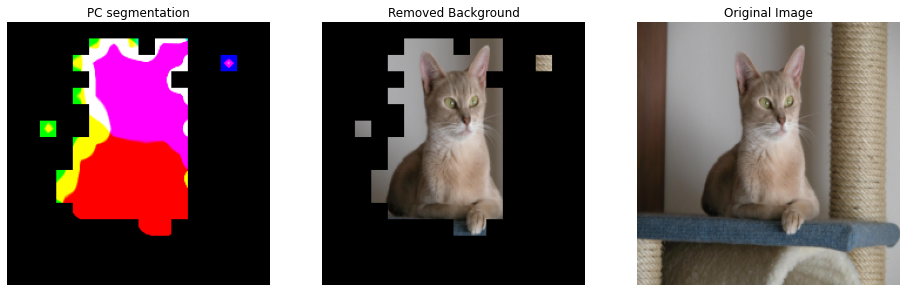

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

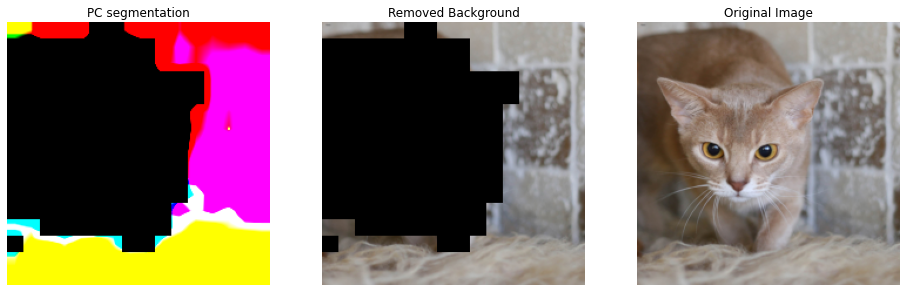

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

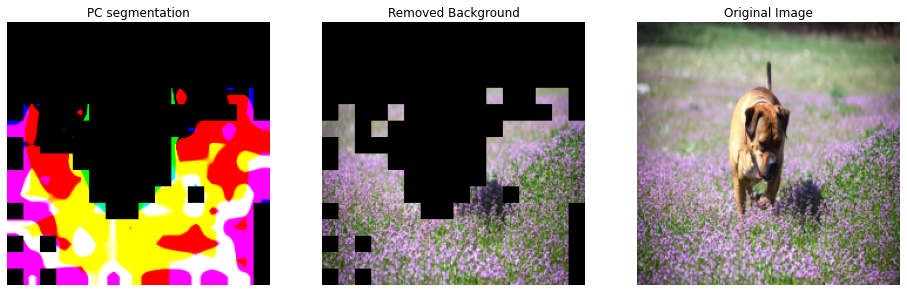

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

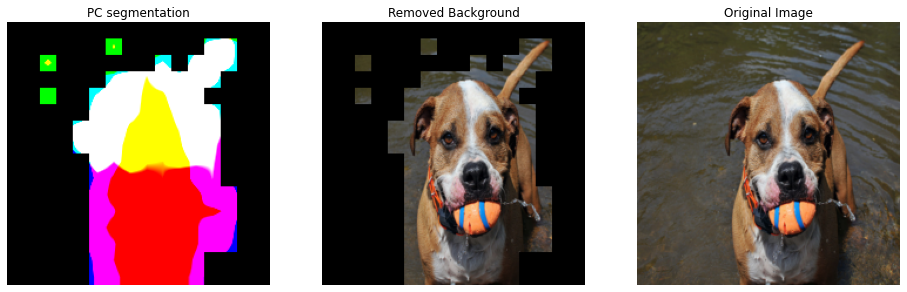

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

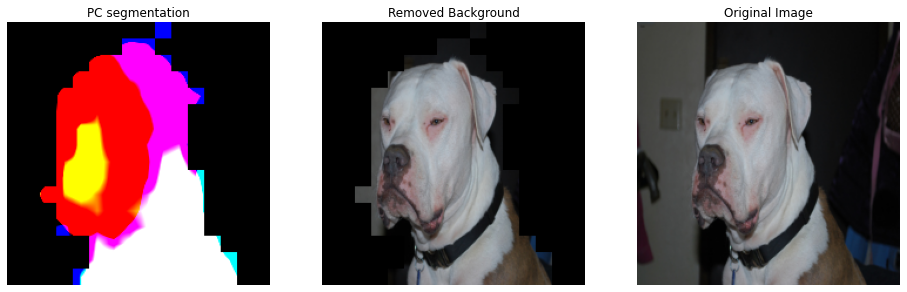

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

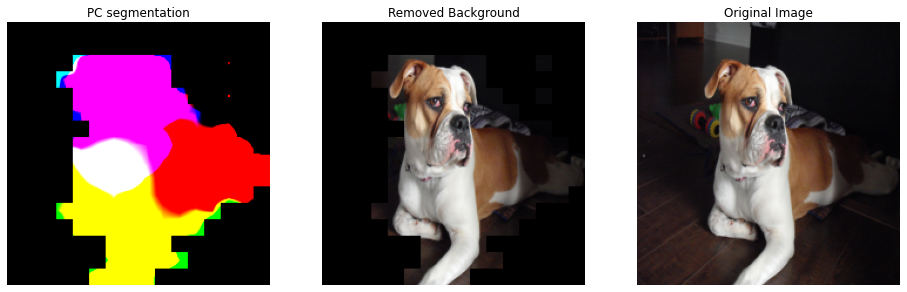

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

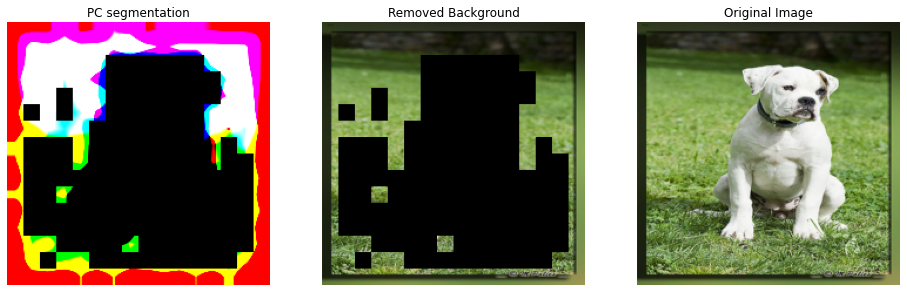

In [81]:
import numpy as np
import cv2  # For image manipulation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import copy
import warnings
import numpy as np

def extract_patches(image, patch_size=(14, 14), stride=14):
    h, w, c = image.shape
    patch_h, patch_w = patch_size
    patches = []
    indices = []

    for i in range(0, h - patch_h + 1, stride):
        for j in range(0, w - patch_w + 1, stride):
            patch = image[i:i + patch_h, j:j + patch_w, :] 
            patches.append(patch)
            indices.append((i, j)) 
    
    patches = np.array(patches)
    return patches, indices



def perform_pca(features, n_components=3):
    pca = PCA(n_components=n_components)
    transformed_features = pca.fit_transform(features)
    return pca, transformed_features


def threshold_pca_component(pca_components, threshold=0):
    first_component = pca_components[:, 0] 
    mask = first_component > threshold  
    return mask


def visualize_pca_results(pca_components, image_shape):
    n_components = pca_components.shape[1]
    
    
    reshaped_components = []
    patch_size = 14  
    num_patches = pca_components.shape[0] 

    
    for i in range(n_components):
    
        reshaped = np.zeros((num_patches // (image_shape[1] // patch_size), image_shape[1] // patch_size))
        reshaped = pca_components[:, i].reshape(reshaped.shape)
        reshaped_components.append(reshaped)

    
    rgb_image = np.stack(reshaped_components[:3], axis=-1)
    return rgb_image
    #plt.imshow(rgb_image, cmap='gray')
    #plt.title("PCA Components Visualization")
    #plt.axis('off')  # Hide axis
    #plt.show()
"""    
def visualize_pca_results(pca_components, num_patches, patch_size):
    n_components = pca_components.shape[1]
    
    
    fig, axes = plt.subplots(1, min(n_components, 3), figsize=(15, 5))  # Limit to 3 components for display

    for i in range(min(n_components, 3)):
        
        reshaped = pca_components[:, i].reshape(int(np.sqrt(num_patches)), int(np.sqrt(num_patches)))
        axes[i].imshow(reshaped, cmap='gray')
        axes[i].set_title(f"PCA Component {i+1}")
        axes[i].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

"""

def process_image(image1):
    image = copy.deepcopy(image1)
    
    features = dinov2_vits14.get_intermediate_layers(image.unsqueeze(0), 1, False)[0]
    features = features.detach().squeeze(0).numpy()
    
    
   
    pca, pca_components = perform_pca(features)

   
    foreground_mask = threshold_pca_component(pca_components)

   
    patches, indices = extract_patches(np.transpose(image, (1, 2, 0)), patch_size=(14, 14), stride=14)

    
    foreground_patches = patches[foreground_mask]

    
    reconstructed_image = np.transpose(image, (1, 2, 0))

    
    
   
    for idx, (is_foreground, (i, j)) in enumerate(zip(foreground_mask, indices)):
        if not is_foreground: 
            reconstructed_image[i:i + 14, j:j + 14, :] = 0
   


    
    new_features = dinov2_vits14.get_intermediate_layers(image1.unsqueeze(0), 1, False)[0].detach().squeeze().numpy()
   # new_features = dinov2_vits14.get_intermediate_layers(reconstructed_image_2.unsqueeze(0), 1, False)[0].detach().squeeze(0).numpy()
    #print(new_features2==new_features)
    
    
    second_pca, second_pca_components = perform_pca(new_features)
    

   
    final = visualize_pca_results(second_pca_components, image1.shape)
    
    final = cv2.resize(final, (224,224))
    for idx, (is_foreground, (i, j)) in enumerate(zip(foreground_mask, indices)):
        if not is_foreground:  
            final[i:i + 14, j:j + 14, :] = 0
    #plt.imshow(final, cmap='gray')
    #plt.title("PCA Components Visualization")
    #plt.axis('off')  # Hide axis
    #plt.show()
    return reconstructed_image, final



with warnings.catch_warnings():
    warnings.simplefilter('ignore')


    for i in range(15):
        plt.figure(i)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
        arr = train_dataset_OxfordIIITPet[i*5][0]
        arr_org = np.transpose(copy.deepcopy(arr.numpy()),(1, 2, 0))

        recon, final = process_image(arr)

        arr = np.transpose(arr, (1, 2, 0))

        ax1.imshow(final, cmap='gray')

        ax1.set_title("PC segmentation")
        ax1.axis('off') 
        ax2.imshow(recon)
        ax2.set_title("Removed Background")
        ax2.axis('off')
        ax3.imshow(arr_org)
        ax3.set_title("Original Image")
        ax3.axis('off')
        plt.show()
